# 2024-026 Differential Peak Analysis - JSB

This notebook describes steps to perform differential peak analysis of published ATAC-seq data from Scott-Browne 2016.

## Initialize Enviroment

In [1]:
# Load Libraries
library(DESeq2)
library(dplyr)
library(ggplot2)
library(viridis)
library(dplyr)
library(tidyr)

# Experiment
exp <- "XZ"          # Khan 2020

# Load data
working_dir <- "/home/dalbao/2024-026-Tcf7ATAC/01_nfcore_241228"
prefix      <- paste("241229_bp_", exp, "_", sep = "")                  # Prefix of save files

# Move to working directory
setwd(working_dir)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
# Load feature counts
featureCounts <- read.table("bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.featureCounts.txt",
                            header = TRUE)

# Remove unnecessary columns

featureCounts <- featureCounts[, -c(2:6)]

# Rename columns
colnames(featureCounts) <- gsub(".mLb.clN.sorted.bam", "", colnames(featureCounts))

# Make intervals as row names
rownames(featureCounts) <- featureCounts$Geneid
featureCounts <- featureCounts[, -1]

# Check
head(featureCounts)

,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_1,2,0,2,0,2,1,2,0,2,1,⋯,5,4,5,4,6,3,2,4,7,7
Interval_2,2,1,10,0,0,2,2,1,2,3,⋯,8,2,5,6,10,7,9,5,7,15
Interval_3,1,1,1,0,3,1,1,0,1,2,⋯,3,2,2,2,2,1,2,5,3,5
Interval_4,1,1,2,0,0,0,0,0,0,0,⋯,4,1,4,1,3,4,1,8,0,3
Interval_5,2,1,0,0,1,2,0,0,0,1,⋯,5,4,5,4,6,1,6,7,6,6
Interval_6,3,3,1,0,1,1,0,0,5,2,⋯,10,2,2,5,0,4,3,8,5,8


In [3]:
# Load sample metadata
sampleMetadata <- read.csv("../metadata/sampleMetadata.csv")

# Make sample names as row names
rownames(sampleMetadata) <- sampleMetadata$Sample
sampleMetadata <- sampleMetadata[, -1]

# Check
head(sampleMetadata)

# Make sure the observations in sampleMetadata are in the same order as the columns in featureCounts
sampleMetadata <- sampleMetadata[colnames(featureCounts), ]

# Load keep peaks file
keep <- read.table("241229_broad_peak_only_kept_peaks.txt", header = TRUE)

# Keep only features (identified by rowname) that are in keep$interval_id
featureCounts <- featureCounts[rownames(featureCounts) %in% keep$interval_id, ]
head(featureCounts)

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
DW_WT_24h_REP2,DW,DW_WT_24h,,,REP2,24,WT,NA,
DW_RUNX3KO_0h_REP2,DW,DW_RUNX3KO_0h,,,REP2,0,RUNX3KO,NA,
DW_RUNX3KO_6h_REP1,DW,DW_RUNX3KO_6h,,,REP1,6,RUNX3KO,NA,
DW_WT_6h_REP1,DW,DW_WT_6h,,,REP1,6,WT,NA,
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,
DW_WT_0h_REP1,DW,DW_WT_0h,,,REP1,0,WT,NA,


,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,17,32,33,35,12,14,80,3,27,61,⋯,234,224,212,147,176,165,240,364,177,128
Interval_103,29,5,28,22,8,9,51,1,3,13,⋯,183,160,117,172,132,179,242,157,216,66
Interval_105,22,37,23,5,33,47,27,9,29,20,⋯,146,133,81,66,80,97,139,117,95,165
Interval_107,12,12,11,4,15,18,26,6,16,19,⋯,82,73,61,49,59,56,86,73,80,131
Interval_108,108,224,160,110,222,194,174,39,247,244,⋯,858,707,482,449,536,594,751,676,531,975
Interval_110,172,210,274,158,274,271,158,57,264,252,⋯,942,771,527,495,480,648,909,740,633,1388


## Perform Analysis on Experiment

In [4]:
# Experiments are tagged with exp tag in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Experiment == exp, ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
Tcm_WT_REP1,XZ,Tcm_WT,Tcm,,,NA,,NA,
Tem_WT_REP1,XZ,Tem_WT,Tem,,,NA,,NA,
Tem_WT_REP2,XZ,Tem_WT,Tem,,,NA,,NA,
Tcm_WT_REP3,XZ,Tcm_WT,Tcm,,,NA,,NA,
Tcm_WT_REP2,XZ,Tcm_WT,Tcm,,,NA,,NA,


,Tcm_WT_REP1,Tem_WT_REP1,Tem_WT_REP2,Tcm_WT_REP3,Tcm_WT_REP2
,<int>,<int>,<int>,<int>,<int>
Interval_98,35,41,30,50,58
Interval_103,22,23,56,23,42
Interval_105,5,7,5,7,4
Interval_107,4,8,14,11,15
Interval_108,110,105,165,149,230
Interval_110,158,174,223,200,278


Create the DESeq2 object:

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance



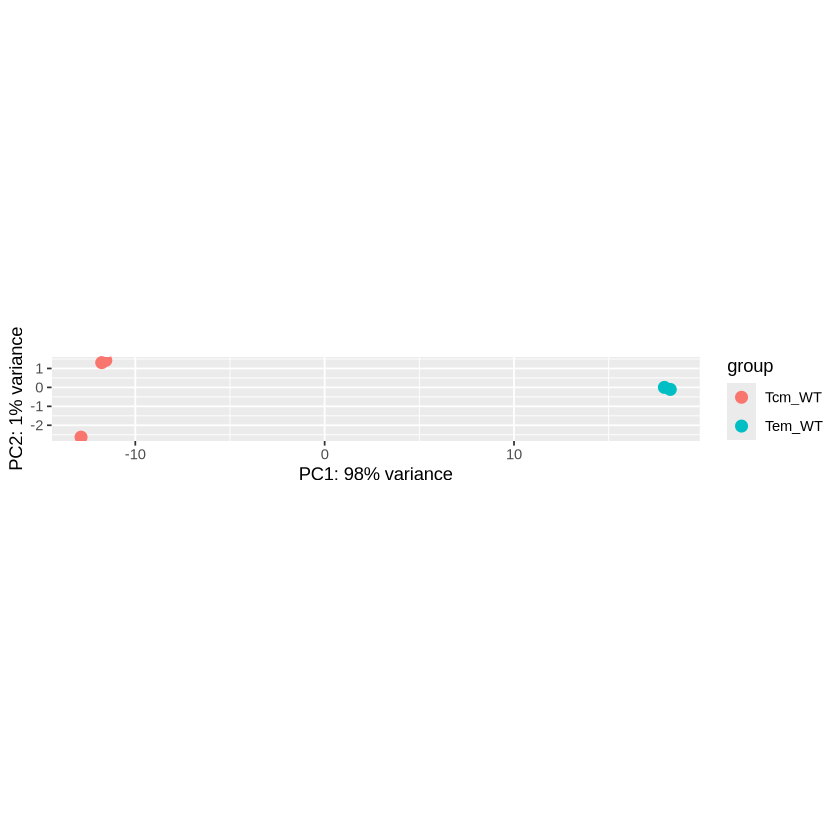

In [5]:
# Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = daExp,
                              colData   = daMeta,
                              design    = ~ Phenotype)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))

## Perform Comparisons and Extract Results

In [6]:
# Load comparisons CSV
comparisons <- read.csv("../metadata/comparisons_rest.csv")

comparisons <- comparisons[comparisons$Experiment == exp, ]

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  res <- lfcShrink( dds,
                    contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]),
                    type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(res),
    baseMean = res$baseMean,
    log2FC = res$log2FoldChange,
    statistic = stat$stat,
    pvalue = res$pvalue,
    padj = res$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(res, stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results <- bind_rows(results)

# Write the combined results dataframe to a CSV file without row names
write.csv(results, file = paste0(prefix, "peakDE.csv"), row.names = FALSE)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



## Count Differential Peaks

### p < 0.1

In [7]:
signif_counts <- function(results, padj_threshold = 0.1) {
    # Filter results for significant genes (padj < 0.1) and save into a new dataframe called "signif"
    signif <- results[results$padj < padj_threshold, ]

    # Create a new column named "direction" in signif and
    # assign "up" if log2FC > 0, "down" if log2FC < 0, and "no change" if log2FC = 0
    signif$direction <- ifelse(signif$log2FC > 0, "up", ifelse(signif$log2FC < 0, "down", "no change"))

    # Count the number of up and down peaks for each comparison in signif
    # Then spread the data to have separate columns for up and down counts
    counts <- signif %>%
    group_by(comparison, direction) %>%
    summarise(count = n()) %>%
    spread(direction, count)

    counts
}

signif_counts(results, padj_threshold = 0.1)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
Tcm_vs_Tem,7808,5155


### p < 0.05

In [8]:
signif_counts(results, padj_threshold = 0.05)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
Tcm_vs_Tem,6810,4016


## Define Peak Lists

Here, I define peak lists for Peak Set Enrichment Analysis (PSEA). First I create functions to do peak intersection.

In [9]:
# Create an empty list called peaks to store the dataframes
peaks <- list()

# Threshholds
pval = 0.05
log2FC = 1.5

# Load functions for peak intersection
source("../define_peak_sets.R")

### Memory and Effector Peaks

Define memory-specific peaks as the intersection of [memory > naive] and [memory > effector] (Scott-Browne, 2016). Other comparisons follow this paradigm.

In [10]:
peaks$TCMxz     <- peak_intersector(de_peaks = results,
                                    comp = c("Tcm_vs_Tem"),
                                    label = "xz_CMvEM",
                                    log2FC_adjuster = c(-1), pval_subset = pval, log2FC_subset = log2FC)


# Combine all peak dataframes into a single dataframe
peaks <- bind_rows(peaks)
table(peaks$peak_set)


xz_CMvEM_closed   xz_CMvEM_open 
            181             309 

### Combine Lists and Save

In [11]:
# Check set counts
table(peaks$peak_set)


xz_CMvEM_closed   xz_CMvEM_open 
            181             309 

In [12]:
# Format to Pipkin lab peak set specifications
# ps_name - peak set name
# peak_symbol - peak symbol
# Keep only ps_name and peak_symbol columns
peaks <- peaks %>%
    mutate( ps_name = peak_set,
            peak_symbol = name) %>%
    select(ps_name, peak_symbol)

head(peaks)

# Write the combined results dataframe to a CSV file without row names
write.csv(peaks, file = paste0(prefix, "peak_sets.csv"), row.names = FALSE)

,ps_name,peak_symbol
,<chr>,<chr>
1,xz_CMvEM_open,Interval_183217
2,xz_CMvEM_open,Interval_180783
3,xz_CMvEM_open,Interval_18841
4,xz_CMvEM_open,Interval_222207
5,xz_CMvEM_open,Interval_64171
6,xz_CMvEM_open,Interval_236130
